# Audio Event Detection via Deep Learning
_Robert Coop, Ph.D._

This is companion code to my talk at DSATL 2018.

## Calculating the spectrograms

In [1]:
import sys
sys.path.insert(0, './dsatl_lib')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pydub import AudioSegment
import librosa
import librosa.display

import vggish_input
import vggish_params
import vggish_postprocess
import vggish_slim
from mel_features import log_mel_spectrogram

In [3]:
def plot_spectrograms(sound):
    samples = sound.get_array_of_samples()
    sarr = np.array(samples, dtype=np.int) / 32768.0

    plt.figure(figsize=(10,8))
    ax = plt.subplot(2,1,1, frameon=True)

#     plt.plot(sarr)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    librosa.display.waveplot(sarr, sr=sound.frame_rate)

#     plt.axis('off')
    plt.title('Sound wave')

    y = sarr
    sr = sound.frame_rate

    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_spec.shape

    ax = plt.subplot(2,1,2, frameon=True)
    librosa.display.specshow(librosa.power_to_db(mel_spec, ref=np.max))
    # plt.colorbar(format='%+2.0f dB')
    plt.title('Mel spectrogram')

#     log_mel = log_mel_spectrogram(sarr, audio_sample_rate=sound.frame_rate, log_offset=0.01)
#     plt.figure(figsize=(10,4))
#     librosa.display.specshow(log_mel.T)
#     # plt.colorbar()
#     plt.title('Log-Mel spectrogram')

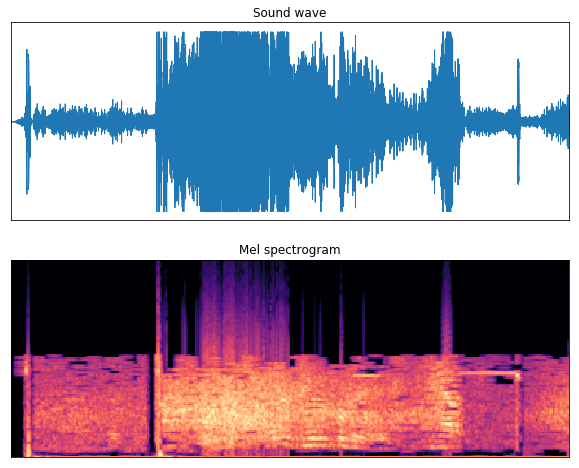

In [4]:
fname = 'dsatl_data/sample1.wav'  # Voices

sound = AudioSegment.from_wav(fname)
plot_spectrograms(sound)

sound

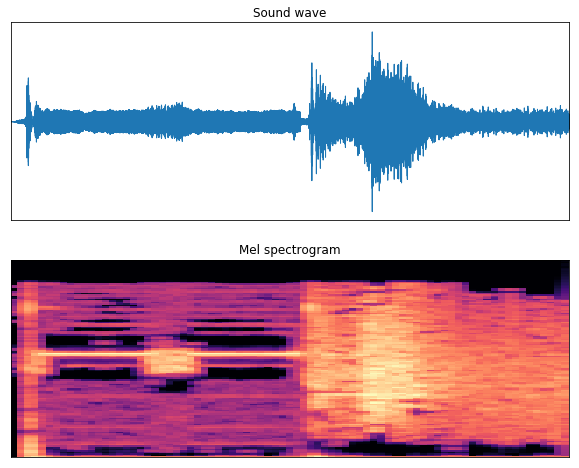

In [5]:
fname = 'dsatl_data/sample2.wav'  # Beep, then static

sound = AudioSegment.from_wav(fname)
plot_spectrograms(sound)

sound

## Working with VGGish

### Preprocessing a WAV

In [6]:
'Common parameters used by vggish:', [vggish_params.STFT_WINDOW_LENGTH_SECONDS, 
 vggish_params.STFT_HOP_LENGTH_SECONDS , 
 vggish_params.EXAMPLE_WINDOW_SECONDS, 
 vggish_params.EXAMPLE_HOP_SECONDS,
 vggish_params.SAMPLE_RATE]

('Common parameters used by vggish:', [0.025, 0.01, 0.96, 0.96, 16000])

In [7]:
import vggish_input
from pydub import AudioSegment

sound = AudioSegment.from_wav('dsatl_data/sample1.wav')
waveform = np.array(sound.get_array_of_samples()) / 32768.0

examples = vggish_input.waveform_to_examples(data=waveform, sample_rate=sound.frame_rate)

In [8]:
examples.shape

(5, 96, 64)

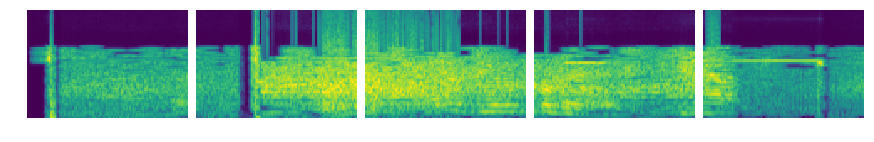

In [9]:
plt.figure(figsize=(15,4))

plt.subplot(1,5,1)
plt.imshow(examples[0].T, origin='lower')
plt.axis('off')

plt.subplot(1,5,2)
plt.imshow(examples[1].T, origin='lower')
plt.axis('off')

plt.subplot(1,5,3)
plt.imshow(examples[2].T, origin='lower')
plt.axis('off')

plt.subplot(1,5,4)
plt.imshow(examples[3].T, origin='lower')
plt.axis('off')

plt.subplot(1,5,5)
plt.imshow(examples[4].T, origin='lower')
plt.axis('off')

plt.subplots_adjust(wspace=0.05)

### Extracting features with VGGish
Reference - https://github.com/tensorflow/models/blob/master/research/audioset/vggish_inference_demo.py

In [10]:
import tensorflow as tf

import vggish_params
import vggish_slim

checkpoint_path = 'dsatl_lib/vggish_model.ckpt'

with tf.Graph().as_default(), tf.Session() as sess:

    vggish_slim.define_vggish_slim()
    vggish_slim.load_vggish_slim_checkpoint(sess, checkpoint_path)

    
    features_tensor = sess.graph.get_tensor_by_name(vggish_params.INPUT_TENSOR_NAME)
    embedding_tensor = sess.graph.get_tensor_by_name(vggish_params.OUTPUT_TENSOR_NAME)
    
    [embedding_batch] = sess.run([embedding_tensor],
                               feed_dict={features_tensor: examples})    

INFO:tensorflow:Restoring parameters from dsatl_lib/vggish_model.ckpt


In [11]:
print(embedding_batch.shape)
embedding_batch[0]

(5, 128)


array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.1921326 , 0.6882812 ,
       0.07536665, 0.21826039, 0.04121792, 0.        , 0.        ,
       0.28663808, 0.6735206 , 0.33129147, 0.        , 0.4089053 ,
       0.28812438, 0.30994707, 0.31793296, 0.        , 0.18748808,
       0.3897941 , 0.10245769, 0.        , 0.4823558 , 0.872372  ,
       0.05292181, 0.        , 0.        , 0.        , 0.3714119 ,
       0.        , 0.3114261 , 0.        , 0.        , 0.67154396,
       0.10126747, 0.06725979, 0.19928011, 0.06335571, 0.01787063,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.03634968, 0.        , 0.        , 0.5160227 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.3708648 , 0.24956195, 0.0450035 ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [12]:
import vggish_postprocess
pproc = vggish_postprocess.Postprocessor('dsatl_lib/vggish_pca_params.npz')
postprocessed_batch = pproc.postprocess(embedding_batch)
print(postprocessed_batch.shape)
postprocessed_batch[0]

(5, 128)


array([162,  37, 190, 114, 255,  96, 110, 131, 206, 221,  68,  41,  82,
       227, 122, 135,  51, 206, 191, 139,  38, 155, 134,  94, 108, 113,
       123, 255, 130, 146, 199, 171, 136, 128,  15, 246,  74, 189, 208,
       129,   0, 142,   0, 255, 189,  98, 196,  89, 145, 255, 218, 173,
       150, 224, 117, 162, 172,   0,  97, 249, 166, 117,  67, 255, 200,
       240, 165, 197, 255, 179, 173, 160, 255, 154, 153, 119, 122, 181,
       119, 184,  28, 165, 133, 255,  66,  68, 255, 255,  93,   0,  89,
       255, 255, 120,  38,  93,  32,  73, 255, 112,  75,  20, 225, 100,
         7, 255, 122, 255, 182, 246, 239,  58, 122,   0, 207, 255, 164,
        54,   0, 192,  69, 255,   0,  18, 255,  59, 255, 255], dtype=uint8)

### Using VGGish as a starter network
Reference - https://github.com/tensorflow/models/blob/master/research/audioset/vggish_train_demo.py

In [13]:
from random import shuffle

def _get_examples_batch():
  """Returns a shuffled batch of examples of all audio classes.

  Note that this is just a toy function because this is a simple demo intended
  to illustrate how the training code might work.

  Returns:
    a tuple (features, labels) where features is a NumPy array of shape
    [batch_size, num_frames, num_bands] where the batch_size is variable and
    each row is a log mel spectrogram patch of shape [num_frames, num_bands]
    suitable for feeding VGGish, while labels is a NumPy array of shape
    [batch_size, num_classes] where each row is a multi-hot label vector that
    provides the labels for corresponding rows in features.
  """
  # Make a waveform for each class.
  num_seconds = 5
  sr = 44100  # Sampling rate.
  t = np.linspace(0, num_seconds, int(num_seconds * sr))  # Time axis.
  # Random sine wave.
  freq = np.random.uniform(100, 1000)
  sine = np.sin(2 * np.pi * freq * t)
  # Random constant signal.
  magnitude = np.random.uniform(-1, 1)
  const = magnitude * t
  # White noise.
  noise = np.random.normal(-1, 1, size=t.shape)

  # Make examples of each signal and corresponding labels.
  # Sine is class index 0, Const class index 1, Noise class index 2.
  sine_examples = vggish_input.waveform_to_examples(sine, sr)
  sine_labels = np.array([[1, 0, 0]] * sine_examples.shape[0])
  const_examples = vggish_input.waveform_to_examples(const, sr)
  const_labels = np.array([[0, 1, 0]] * const_examples.shape[0])
  noise_examples = vggish_input.waveform_to_examples(noise, sr)
  noise_labels = np.array([[0, 0, 1]] * noise_examples.shape[0])

  # Shuffle (example, label) pairs across all classes.
  all_examples = np.concatenate((sine_examples, const_examples, noise_examples))
  all_labels = np.concatenate((sine_labels, const_labels, noise_labels))
  labeled_examples = list(zip(all_examples, all_labels))
  shuffle(labeled_examples)

  # Separate and return the features and labels.
  features = [example for (example, _) in labeled_examples]
  labels = [label for (_, label) in labeled_examples]
  return (features, labels)


In [14]:

slim = tf.contrib.slim
_NUM_CLASSES = 3


with tf.Graph().as_default(), tf.Session() as sess:
    # Define VGGish.
    embeddings = vggish_slim.define_vggish_slim(training=True)
    
    # Define a shallow classification model and associated training ops on top
    # of VGGish.
    with tf.variable_scope('mymodel'):
        # Add a fully connected layer with 100 units.
        num_units = 100
        fc = slim.fully_connected(embeddings, num_units)
        
        # Add a classifier layer at the end, consisting of parallel logistic
        # classifiers, one per class. This allows for multi-class tasks.
        logits = slim.fully_connected(
          fc, _NUM_CLASSES, activation_fn=None, scope='logits')
        tf.sigmoid(logits, name='prediction')
        
        

          # Add training ops.
        with tf.variable_scope('train'):
            global_step = tf.Variable(
                0, name='global_step', trainable=False,
                collections=[tf.GraphKeys.GLOBAL_VARIABLES,
                             tf.GraphKeys.GLOBAL_STEP])

            # Labels are assumed to be fed as a batch multi-hot vectors, with
            # a 1 in the position of each positive class label, and 0 elsewhere.
            labels = tf.placeholder(
                tf.float32, shape=(None, _NUM_CLASSES), name='labels')

            # Cross-entropy label loss.
            xent = tf.nn.sigmoid_cross_entropy_with_logits(
                logits=logits, labels=labels, name='xent')
            loss = tf.reduce_mean(xent, name='loss_op')
            tf.summary.scalar('loss', loss)

            # We use the same optimizer and hyperparameters as used to train VGGish.
            optimizer = tf.train.AdamOptimizer(
                learning_rate=vggish_params.LEARNING_RATE,
                epsilon=vggish_params.ADAM_EPSILON)
            optimizer.minimize(loss, global_step=global_step, name='train_op')

    # Initialize all variables in the model, and then load the pre-trained
    # VGGish checkpoint.
    sess.run(tf.global_variables_initializer())
    vggish_slim.load_vggish_slim_checkpoint(sess, checkpoint_path)

    # Locate all the tensors and ops we need for the training loop.
    features_tensor = sess.graph.get_tensor_by_name(
        vggish_params.INPUT_TENSOR_NAME)
    labels_tensor = sess.graph.get_tensor_by_name('mymodel/train/labels:0')
    global_step_tensor = sess.graph.get_tensor_by_name(
        'mymodel/train/global_step:0')
    loss_tensor = sess.graph.get_tensor_by_name('mymodel/train/loss_op:0')
    train_op = sess.graph.get_operation_by_name('mymodel/train/train_op')

    # The training loop.
    for _ in range(10):
        (features, labels) = _get_examples_batch()
        [num_steps, loss, _] = sess.run(
          [global_step_tensor, loss_tensor, train_op],
          feed_dict={features_tensor: features, labels_tensor: labels})
        print('Step %d: loss %g' % (num_steps, loss))


INFO:tensorflow:Restoring parameters from dsatl_lib/vggish_model.ckpt
Step 1: loss 0.697337
Step 2: loss 0.670463
Step 3: loss 0.651472
Step 4: loss 0.632244
Step 5: loss 0.613149
Step 6: loss 0.589625
Step 7: loss 0.582047
Step 8: loss 0.565822
Step 9: loss 0.549078
Step 10: loss 0.535516


## Augmenting data

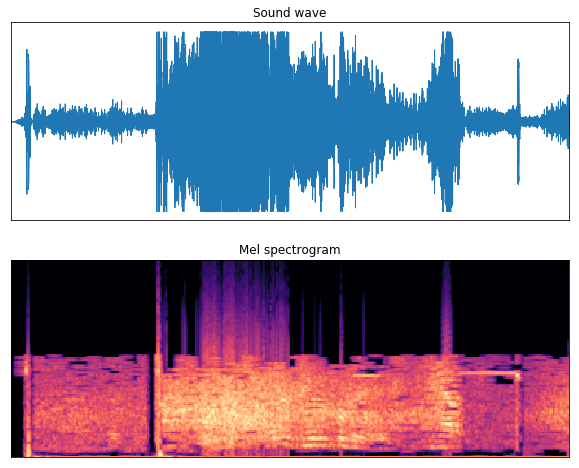

In [15]:
fname = 'dsatl_data/sample1.wav'  # Voices
sound = AudioSegment.from_wav(fname)
plot_spectrograms(sound)
sound

#### Adding noise

In [16]:
from array import array

fname = 'dsatl_data/sample1.wav'  # Voices
sound = AudioSegment.from_wav(fname)
samples = sound.get_array_of_samples()

noise_amp = 0.75
noisy_array = samples + noise_amp * np.random.normal(np.mean(samples),
                                                     noise_amp * np.std(samples),
                                                     len(samples))
noisy_array[ noisy_array < -32768 ] = -32768
noisy_array[ noisy_array > 32767 ] = 32767

y_noise = array(samples.typecode)
y_noise.fromlist(noisy_array.astype(int).tolist())

noisy_sound = AudioSegment(data=y_noise, sample_width=sound.sample_width,
                          frame_rate=sound.frame_rate, channels=sound.channels)

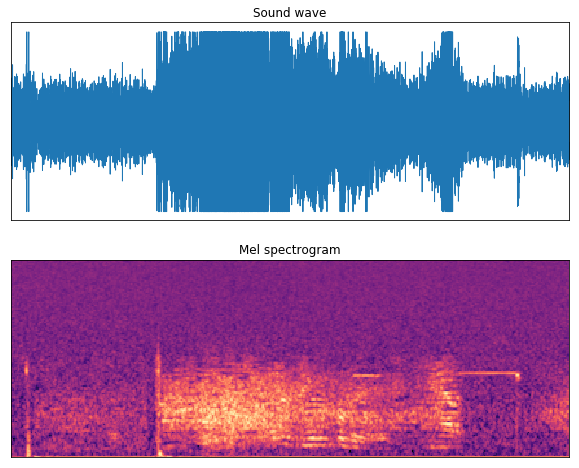

In [17]:
plot_spectrograms(noisy_sound)

noisy_sound

In [18]:
noisy_sound.export('./dsatl_data/sample1_awgn.wav', format='wav');

#### Rolling

In [19]:
fname = 'dsatl_data/sample1.wav'  # Voices
sound = AudioSegment.from_wav(fname)
samples = sound.get_array_of_samples()

roll = np.random.randint(0,high=len(samples),size=1)
rolled_samples = np.roll(samples, roll)

y_noise = array(samples.typecode)
y_noise.fromlist(rolled_samples.tolist())

rolled_sound = AudioSegment(data=y_noise, sample_width=sound.sample_width,
                          frame_rate=sound.frame_rate, channels=sound.channels)

print('Rolled by {}'.format(roll))

Rolled by [34046]


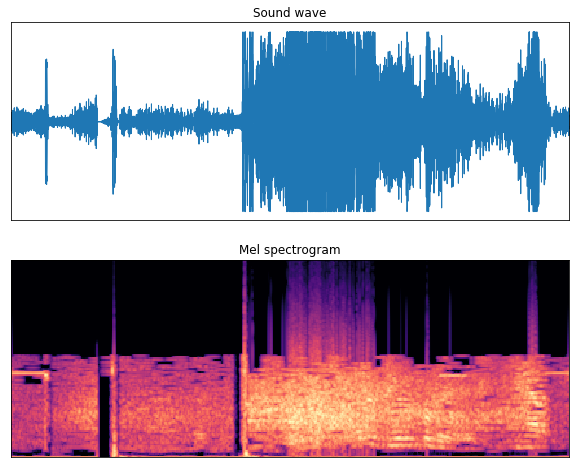

In [20]:
plot_spectrograms(rolled_sound)
rolled_sound

In [21]:
rolled_sound.export('./dsatl_data/sample1_roll.wav', format='wav');

#### Changing pitch

In [22]:
fname = 'dsatl_data/sample1.wav'  # Voices
sound = AudioSegment.from_wav(fname)
samples = sound.get_array_of_samples()

y_pitch = np.array(samples, dtype=np.float64)
bins_per_octave = 24
pitch_pm = 4
pitch_change =  pitch_pm * 20 *(np.random.uniform()-0.5)   
print("pitch_change = ",pitch_change)
y_pitch = librosa.effects.pitch_shift(y_pitch, 
                                      sound.frame_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)


y_noise = array(samples.typecode)
y_noise.fromlist(y_pitch.round().astype(np.int16).tolist())

pitch_sound = AudioSegment(data=y_noise, sample_width=sound.sample_width,
                          frame_rate=sound.frame_rate, channels=sound.channels)

('pitch_change = ', 26.953682852637108)


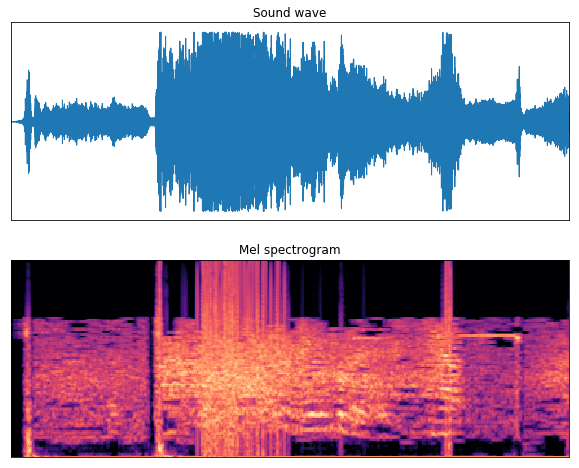

In [23]:
plot_spectrograms(pitch_sound)
pitch_sound

In [24]:
pitch_sound.export('./dsatl_data/sample1_pitch.wav', format='wav');